<a href="https://colab.research.google.com/github/goldenspring6622/CS114.M21.N02/blob/main/Toxic_Comment_Detection_On_Youtube_Football_Livestream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### IMPORT PACKAGES

In [ ]:
! pip install openpyxl
#Documentation : https://openpyxl.readthedocs.io/en/stable/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install tensorflow tensorflow-gpu pandas matplotlib sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip3 install  xlrd==1.2.0
!pip install --upgrade pandas
!pip install underthesea
import os
import pandas as pd
import tensorflow as tf
import numpy as np
import time
from pandas import Series, DataFrame
import xlrd
from sklearn.feature_extraction.text import TfidfVectorizer
from xlrd import open_workbook
from underthesea import word_tokenize #Documentation :https://pypi.org/project/underthesea/ 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 1. Preprocess

In [ ]:
!pip list

Package                       Version
----------------------------- ------------------------------
absl-py                       1.1.0
alabaster                     0.7.12
albumentations                0.1.12
altair                        4.2.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arviz                         0.12.1
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
atari-py                      0.2.9
atomicwrites                  1.4.0
attrs                         21.4.0
audioread                     2.1.9
autograd                      1.4
Babel                         2.10.2
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        5.0.0
blis                          0.7.7
bokeh                         2.3.3
branca                        0.5.0
bs4                           0.0.1
CacheControl                  0.

In [ ]:
dataTrainUIT = open_workbook("/content/dataset_main.xlsx", encoding_override='latin')
df = pd.read_excel(dataTrainUIT)


In [ ]:
df.head()

,Content,Final
0,VN cố lên nha,0
1,90 phút nữa,0
2,các cầu thủ hãy cố gắng da hết mình nhé . nhất...,0
3,nhật ăn 3:0 r,0
4,1-0 cho vn,0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Count of Toxic Comment of Dataset')

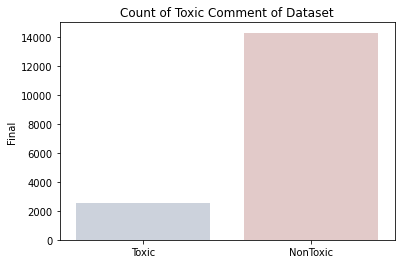

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(['Toxic', 'NonToxic'], df['Final'].map({0:"Non Toxic", 1: "Toxic"}).value_counts(ascending=True), alpha=0.8,palette="vlag")

plt.title('Count of Toxic Comment of Dataset')

In [ ]:
from tensorflow.keras.layers import TextVectorization

In [ ]:
X = df['Content']
y = df['Final']
WordSeg = []
for i in range(len(X)):
        sentence_strip = str(X[i]).strip()# Remove spaces at begin & end
        WordSeg.append(word_tokenize(sentence_strip, format='text')) # format text: add "_" where text is phrases.
X = pd.DataFrame(WordSeg) # Update new sentences
print(X)

                                                       0
0                                          VN cố lên nha
1                                            90 phút nữa
2      các cầu_thủ hãy cố_gắng da hết_mình nhé . nhất...
3                                        nhật ăn 3 : 0 r
4                                             1-0 cho vn
...                                                  ...
16798                                    đá vẫn chán lắm
16799                            vaooooooooooooooooooooo
16800                                           yeahhhhh
16801                     ghi_bàn rồi sẽ giải_toả tâm_lí
16802                      SUIIIIIIIIIIIIIIIIIIIIIIIIIII

[16803 rows x 1 columns]


In [ ]:
MAX_FEATURES = 200000 # number of words in the vocab

In [ ]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=50,
                               output_mode='int')

In [ ]:
vectorizer.adapt(X.values)

In [ ]:
vectorized_text = vectorizer(X.values)

In [ ]:
print(vectorized_text)

tf.Tensor(
[[   3   29   16 ...    0    0    0]
 [ 831  141   65 ...    0    0    0]
 [  64  142  584 ...    0    0    0]
 ...
 [4703    0    0 ...    0    0    0]
 [ 241    8  152 ...    0    0    0]
 [5847    0    0 ...    0    0    0]], shape=(16803, 50), dtype=int64)


In [ ]:
print(vectorized_text)

tf.Tensor(
[[   3   29   16 ...    0    0    0]
 [ 831  141   65 ...    0    0    0]
 [  64  142  584 ...    0    0    0]
 ...
 [4703    0    0 ...    0    0    0]
 [ 241    8  152 ...    0    0    0]
 [5847    0    0 ...    0    0    0]], shape=(16803, 50), dtype=int64)


In [ ]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [ ]:
train = dataset.take(int(len(dataset)*.6))#Train set 60%
val = dataset.skip(int(len(dataset)*.6)).take(int(len(dataset)*.2))#Valuating set 20%
test = dataset.skip(int(len(dataset)*.8)).take(int(len(dataset)*.2))#Test set 20%

# 2. Create Sequential Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [ ]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(512, activation='relu'))
# Final layer 
model.add(Dense(1, activation='sigmoid'))

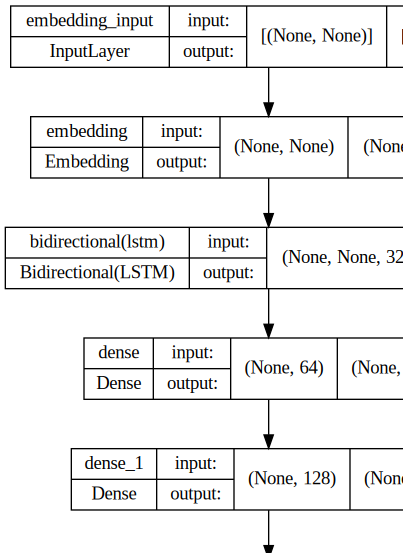

In [ ]:
import keras
%matplotlib inline 

from keras.utils.vis_utils import plot_model
plot_model(model, to_file='cnn_model.png')

# show model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 512)               131584    
                                                                 
 dense_3 (Dense)             (None, 1)                 513       
                                                        

In [ ]:
history = model.fit(train, epochs=15, validation_data=val)

Epoch 1/15
630/630 [==============================] - 70s 97ms/step - loss: 0.2859 - val_loss: 0.1664
Epoch 2/15
630/630 [==============================] - 58s 93ms/step - loss: 0.1539 - val_loss: 0.1061
Epoch 3/15
630/630 [==============================] - 58s 93ms/step - loss: 0.1143 - val_loss: 0.0807
Epoch 4/15
630/630 [==============================] - 61s 96ms/step - loss: 0.0955 - val_loss: 0.0736
Epoch 5/15
630/630 [==============================] - 59s 93ms/step - loss: 0.0800 - val_loss: 0.0580
Epoch 6/15
630/630 [==============================] - 60s 96ms/step - loss: 0.0643 - val_loss: 0.0541
Epoch 7/15
630/630 [==============================] - 57s 91ms/step - loss: 0.0590 - val_loss: 0.0351
Epoch 8/15
630/630 [==============================] - 58s 92ms/step - loss: 0.0551 - val_loss: 0.0332
Epoch 9/15
630/630 [==============================] - 58s 91ms/step - loss: 0.0428 - val_loss: 0.0354
Epoch 10/15
630/630 [==============================] - 59s 93ms/step - loss: 0.046

In [ ]:
from matplotlib import pyplot as plt

<Figure size 576x360 with 0 Axes>

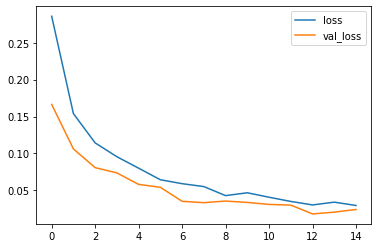

In [ ]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

# 3. Make Predictions

In [ ]:
input_text = vectorizer(['tụi m giỏi thì vào mà đá, ở đó mà sủa ngu'])

In [ ]:
print(input_text)

tf.Tensor(
[[295 117 247  14  17  11   2 149 122  11 849 112   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0]], shape=(1, 50), dtype=int64)


In [ ]:
res = model.predict(input_text)

In [ ]:
print(res)

[[0.9999968]]


In [ ]:
(res > 0.5).astype(int)

array([[1]])

In [ ]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [ ]:
(model.predict(batch_X) > 0.5).astype(int)

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0]])

In [ ]:
res.shape

(1, 1)

In [ ]:
input_text = vectorizer(['Việt Nam vô địch'])

In [ ]:
print(input_text)

tf.Tensor(
[[  38   34  102 1152    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]], shape=(1, 50), dtype=int64)


In [ ]:
res = model.predict(input_text)

In [ ]:
print(res)

[[0.0001933]]


In [ ]:
(res > 0.5).astype(int)

array([[0]])

In [ ]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [ ]:
(model.predict(batch_X) > 0.5).astype(int)

array([[0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])

In [ ]:
res.shape

(1, 1)

In [ ]:
input_text = vectorizer(['Việt Nam vô địt'])

In [ ]:
print(input_text)

tf.Tensor(
[[ 38  34 102 694   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0]], shape=(1, 50), dtype=int64)


In [ ]:
res = model.predict(input_text)

In [ ]:
print(res)

[[0.9999999]]


In [ ]:
(res > 0.5).astype(int)

array([[1]])

In [ ]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [ ]:
(model.predict(batch_X) > 0.5).astype(int)

array([[0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0]])

In [ ]:
res.shape

(1, 1)

In [ ]:
input_text = vectorizer(['chửi chết nó đi anh em'])

In [ ]:
print(input_text)

tf.Tensor(
[[249 228  20  15  66 113   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0]], shape=(1, 50), dtype=int64)


In [ ]:
res = model.predict(input_text)

In [ ]:
print(res)

[[0.9966396]]


In [ ]:
(res > 0.5).astype(int)

array([[1]])

In [ ]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [ ]:
(model.predict(batch_X) > 0.5).astype(int)

array([[0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])

In [ ]:
res.shape

(1, 1)

# 4. Evaluate Model

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [ ]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [ ]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    print(batch)
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    print(y_true)
    yhat = yhat.flatten()
    print(yhat)
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)
    print(pre.result(),re.result(),acc.result())

Streaming output truncated to the last 5000 lines.
           0,    0,    0,    0,    0,    0],
       [7600,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0]]), array([0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]))
[0 0 1 1 0 0 0 1 0 1 0 0 0 0 0 0]
[6.2741369e-02 1.6753568e-10 9.9999940e-01 9.9999970e-01 5.2638502e-06
 8.6258251e-07 7.7786535e-07 9.9860811e-01 1.3745430e-05 1.0000000e+00
 1.0749825e-10 6.9347408e-09 7.6928478e-07 6.1277251e-07 9.1547978e-01
 8.3237131e-07]
tf.Tensor(0.969863, shape=(), dtype=float32) tf.Tensor(0.97252744, shape=(), dtype=float32) tf.Tensor(0.47368422, shape=(), dtype=float32)
(array([[  32,   26,   44,  189,   43,   37,    0,    0,    0,    0,    0,
           0,    0,    0,  

In [ ]:
"""from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))"""
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, F1 Score: {2*pre.result().numpy()*re.result().numpy()/(pre.result().numpy()+re.result().numpy())}, Accuracy:{acc.result().numpy()}')

Precision: 0.974155068397522, Recall:0.966469407081604, F1 Score: 0.9702970185689791, Accuracy:0.4714285731315613
